# Investigation of Public WasteWater Sequences

The following code chunk loads the required packages and defines some helper functions.

In [1]:
suppressPackageStartupMessages({
    library(dplyr)
    library(here)
    library(ggplot2)
    theme_set(theme_bw())
    library(lubridate)
    library(provoc)
    library(tictoc)
})
full_varmat <- astronomize()

# Loads by Bioproject Accession Number.
# runtables must already be downloaded.
load_prj <- function(prj) {
    read.csv(here("data", "runtables",
        paste0("SraRunTable_", prj, ".txt")))
}

# Removes columns with only one unique value
rm_ones <- function(prj_df) {
    ones <- apply(prj_df, 2, function(x) length(unique(x))) == 1
    ones[names(prj_df) == "BioProject"] <- FALSE
    prj_df <- prj_df[!ones]
    prj_df
}

# Visually tests for temporal regularity in sampling
diff_dates <- function(df, col = "wwtp", plot = TRUE, ...) {
    tmp <- bind_rows(lapply(unique(df[, col]), function(x) {
        n <- sum(df[, col] == x)
        thisdate <- ymd(df$Collection_Date[df[, col] == x])
        tmp <- data.frame(
            wwtp = x,
            diffs = as.numeric(diff(sort(ymd(thisdate)))),
            date_low = sort(thisdate)[1:(n - 1)],
            date_high = sort(thisdate)[2:n]
        )
        tmp$mean_date <- as.Date(
            as.numeric(as.Date(tmp$date_low)) / 2 +
                as.numeric(as.Date(tmp$date_high)) / 2,
            origin = "1970-01-01")
        tmp
    }))

    if (plot) {
        plot(x = as.Date(df$Collection_Date), 
            y = as.factor(df[, col]), pch = "|", 
            yaxt = "n", cex = 2, ...)
        yticks <- rev(unique(as.numeric(as.factor(df[, col]))))
        axis(2, at = yticks, labels = sort(levels(as.factor(df[, col]))))
        text(x = tmp[, "mean_date"],
            y = as.numeric(as.factor(tmp[, "wwtp"])),
            labels = tmp[, "diffs"])
        return(invisible())
    } else {
        return(tmp)
    }
}

# Also tests for temporal regularity
table_regularity <- function(dates, wwtps, mindays = 1) {
    t1 <- table(wwtps, dates)
    t1 <- t1[, order(colnames(t1))]
    ismin <- apply(t1, 2, function(x) sum(x > 0) >= mindays)
    t1 <- t1[, ismin]
    colnames(t1) <- c(0, diff(as.numeric(ymd(colnames(t1)))))
    t1
}


### Baaijens - PRJNA741211

These particular data are from New Haven, Connecticut.

In [2]:
baaijens <- load_prj("PRJNA741211")
baaijens <- rm_ones(baaijens) 
head(baaijens, 3)


,Run,Bases,BioProject,BioSample,Bytes,Collection_Date,DATASTORE.filetype,DATASTORE.provider,DATASTORE.region,Experiment,Library.Name,create_date,Sample.Name
,<chr>,<int>,<chr>,<chr>,<int>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>
1,SRR15505102,585534814,PRJNA741211,SAMN20813849,192757947,2021-01-19,"fastq,activ_sars2_vcf,sra,run.zq","ncbi,gs,s3","ncbi.public,s3.us-east-1,gs.US",SRX11804459,DU1,2021-08-17T19:26:00Z,DU1
2,SRR15505103,484944654,PRJNA741211,SAMN20813848,159000482,2021-01-17,"activ_sars2_vcf,run.zq,fastq,sra","s3,gs,ncbi","s3.us-east-1,gs.US,ncbi.public",SRX11804458,DS2,2021-08-17T19:26:00Z,DS2
3,SRR15505104,412520222,PRJNA741211,SAMN20813847,139871000,2021-01-15,"activ_sars2_vcf,sra,fastq,run.zq","ncbi,s3,gs","s3.us-east-1,ncbi.public,gs.US",SRX11804457,DR2,2021-08-17T19:25:00Z,DR2


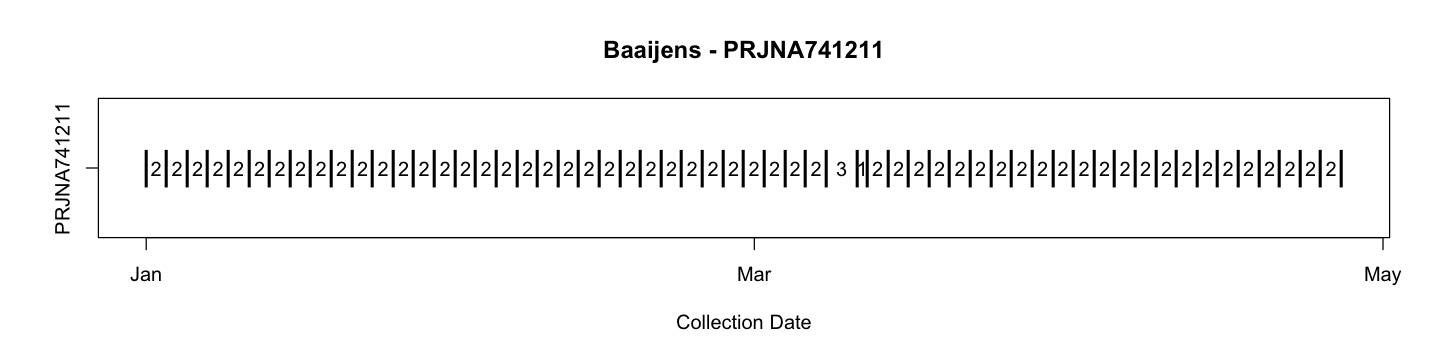

In [3]:
options(repr.plot.width=12, repr.plot.height=3)
diff_dates(baaijens, col = "BioProject", 
    xlab = "Collection Date", ylab = "", 
    main = "Baaijens - PRJNA741211")


Other than one sample that was a day late, there were always two time periods (days) between samples.

In [4]:
tic()
coco <- read.csv(here("data/processed/PRJNA741211_processed.csv.gz"))
coco$mutation <- parse_mutations(coco$label)
varmat <- full_varmat[rownames(full_varmat) %in% c("B.1.427", "B.1.429", "B.1.526", "B.1.1.7", "B.1.351", "B.1.525"), ]
toc()


1.634 sec elapsed


In [5]:
names(coco)


[1] "position"     "label"        "frequency"    "coverage"     "count"       
 [6] "sra"          "avg_spot_len" "sample_name"  "bases"        "bioproject"  
[11] "date"         "mutation"

In [6]:
tic()
Baaijens_lineages <- filter_lineages(full_varmat,
    lineages = c("B.1.427", "B.1.429", "B.1.526", "B.1.1.7", "B.1.351", "B.1.525")
)
Baaijens_res <- provoc(count / coverage ~ ., 
    lineage_defs = Baaijens_lineages,
    by = "sra",
    data = coco)
toc()


Warning message in rep(10, length = nrow(lineage_defs)):
"first element used of 'length.out' argument"
Warning message in optim(theta.old, fun, gradient, control = control, method = method, :
"one-dimensional optimization by Nelder-Mead is unreliable:
use "Brent" or optimize() directly"
Warning message in optim(theta.old, fun, gradient, control = control, method = method, :
"one-dimensional optimization by Nelder-Mead is unreliable:
use "Brent" or optimize() directly"
Warning message in optim(theta.old, fun, gradient, control = control, method = method, :
"one-dimensional optimization by Nelder-Mead is unreliable:
use "Brent" or optimize() directly"
Warning message in optim(theta.old, fun, gradient, control = control, method = method, :
"one-dimensional optimization by Nelder-Mead is unreliable:
use "Brent" or optimize() directly"
Warning message in rep(10, length = nrow(lineage_defs)):
"first element used of 'length.out' argument"
Warning message in optim(theta.old, fun, gradient, con

3.907 sec elapsed


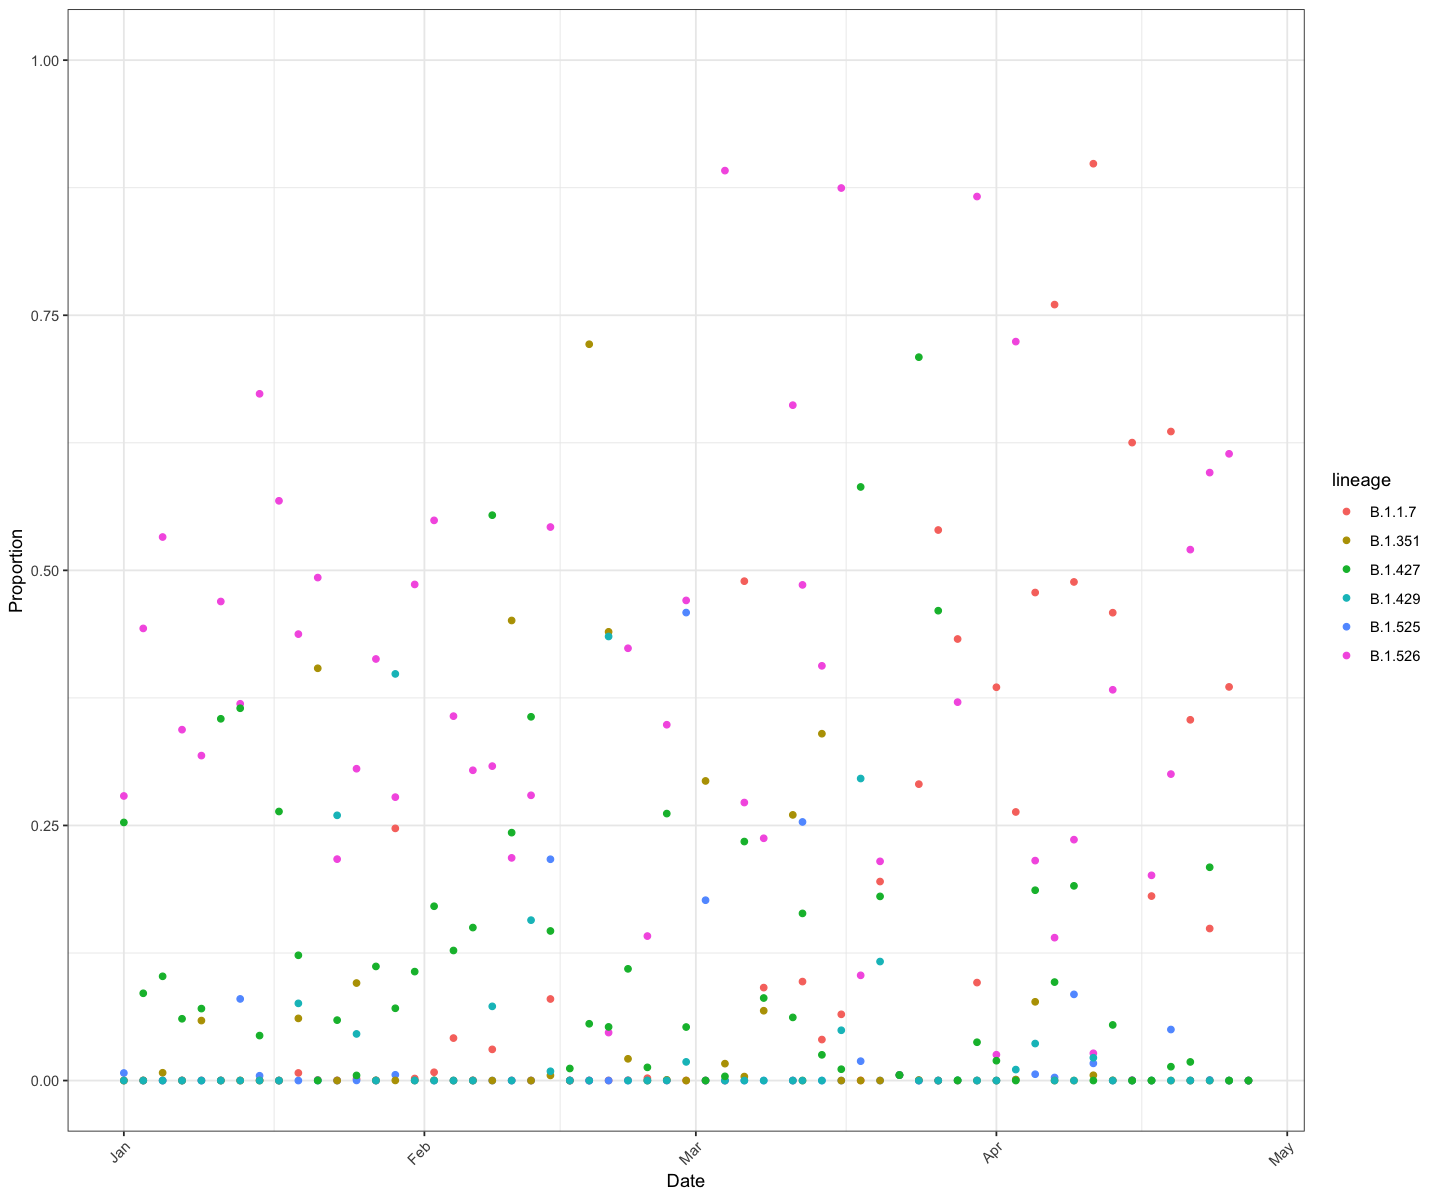

In [7]:
options(repr.plot.width=12, repr.plot.height=10)
Baaijens_res$date <- ymd(Baaijens_res$date)
autoplot(Baaijens_res, date_col = "date")


##### Conclusions

- One WWTP
- VERY regular sampling
- All estimates from ProVoC are pretty low, with no clear "dominant" lineage. 
    - These data are from early 2021, before variants were labelled as "variants of concern". 

# Jahn - PRJEB44932

In [8]:
jahn <- load_prj("PRJEB44932") |> rm_ones()
jahn$wwtp <- substr(jahn$geographic_location_.region_and_locality.,
    1, 2)
head(jahn, 3)


,Run,AvgSpotLen,Bases,BioProject,BioSample,Bytes,Collection_Date,DATASTORE.filetype,DATASTORE.provider,DATASTORE.region,⋯,INSDC_first_public,INSDC_last_update,Instrument,ReleaseDate,run_date..run.,Sample.Name,Sample_Name,Submitter_Id,geographic_location_.region_and_locality.,wwtp
,<chr>,<int>,<dbl>,<chr>,<chr>,<dbl>,<chr>,<chr>,<chr>,<chr>,⋯,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>
1,ERR5922333,502,205750724,PRJEB44932,SAMEA8745890,89541277,2020-07-23,"cram,activ_sars2_vcf,sra","s3,gs","s3.us-east-1,gs.US",⋯,2021-05-17T12:31:43Z,2021-05-17T12:31:43Z,Illumina MiSeq,2021-05-19T00:00:00Z,2020-12-15,SAMEA8745890,10_2020_7_23,10_2020_7_23,ZH - Z<c3><bc>rich - ARA Werdh<c3><b6>lzli,ZH
2,ERR9861200,502,2778133762,PRJEB44932,SAMEA110148731,387121130,2021-11-24,"activ_sars2_vcf,cram,sra","gs,s3","s3.us-east-1,gs.US",⋯,2022-06-20T04:17:33Z,2022-06-20T04:17:33Z,Illumina NovaSeq 6000,2022-06-20T00:00:00Z,2021-12-10,SAMEA110148731,05_2021_11_24,05_2021_11_24,TI - Lugano - CDA Lugano,TI
3,ERR9861201,502,2566883126,PRJEB44932,SAMEA110148732,377298030,2021-11-25,"activ_sars2_vcf,cram,sra","gs,s3","gs.US,s3.us-east-1",⋯,2022-06-20T04:17:33Z,2022-06-20T04:17:33Z,Illumina NovaSeq 6000,2022-06-20T00:00:00Z,2021-12-10,SAMEA110148732,05_2021_11_25,05_2021_11_25,TI - Lugano - CDA Lugano,TI


In [9]:
table(jahn$wwtp)



     BE  GR  SG  Sk  TI  VD  ZH 
 15 304 290 299  10 301 239 365 

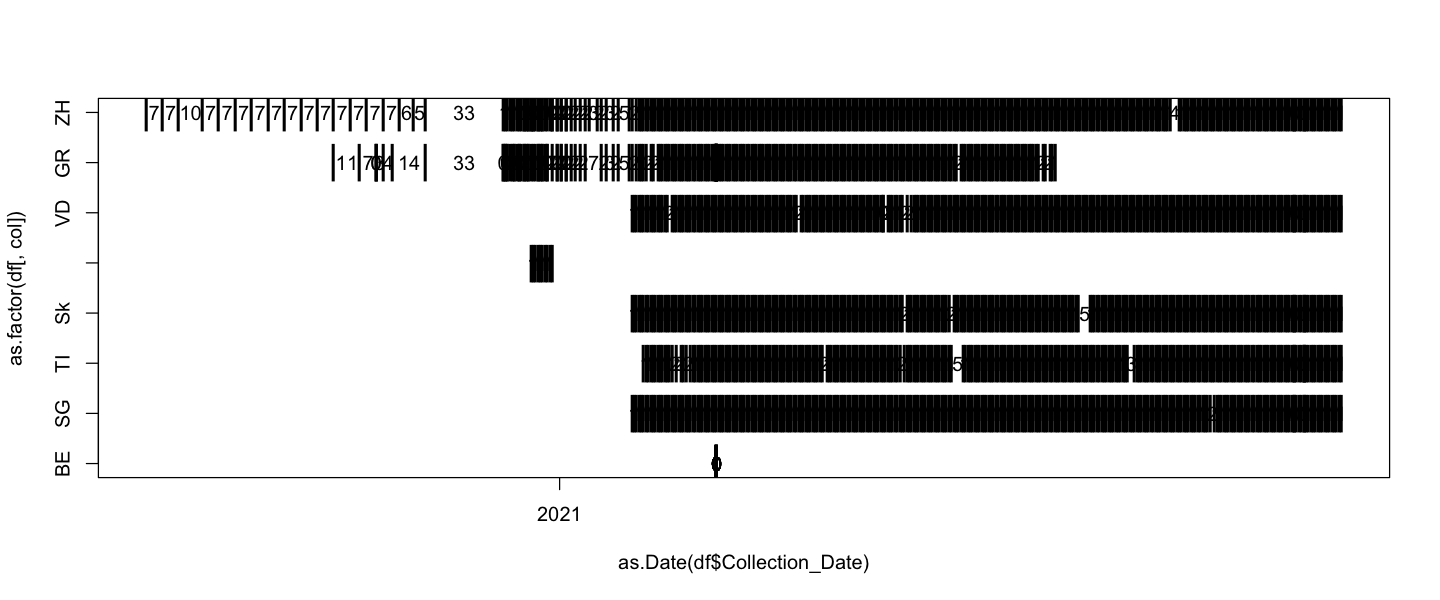

In [10]:
options(repr.plot.width=12, repr.plot.height=5)
diff_dates(jahn, "wwtp")


In [11]:
table_regularity(jahn$Collection_Date, jahn$wwtp) |> colnames() |> unlist()


[1] "0"  "7"  "7"  "10" "7"  "7"  "7"  "7"  "7"  "7"  "7"  "7"  "7"  "4"  "3" 
 [16] "4"  "3"  "4"  "3"  "6"  "5"  "33" "1"  "1"  "1"  "1"  "1"  "1"  "1"  "1" 
 [31] "1"  "1"  "1"  "1"  "1"  "1"  "1"  "1"  "1"  "1"  "1"  "1"  "1"  "2"  "2" 
 [46] "2"  "2"  "2"  "2"  "2"  "2"  "3"  "2"  "2"  "3"  "2"  "5"  "1"  "1"  "1" 
 [61] "1"  "1"  "1"  "1"  "1"  "1"  "1"  "1"  "1"  "1"  "1"  "1"  "1"  "1"  "1" 
 [76] "1"  "1"  "1"  "1"  "1"  "1"  "1"  "1"  "1"  "1"  "1"  "1"  "1"  "1"  "1" 
 [91] "1"  "1"  "1"  "1"  "1"  "1"  "1"  "1"  "1"  "1"  "1"  "1"  "1"  "1"  "1" 
[106] "1"  "1"  "1"  "1"  "1"  "1"  "1"  "1"  "1"  "1"  "1"  "1"  "1"  "1"  "1" 
[121] "1"  "1"  "1"  "1"  "1"  "1"  "1"  "1"  "1"  "1"  "1"  "1"  "1"  "1"  "1" 
[136] "1"  "1"  "1"  "1"  "1"  "1"  "1"  "1"  "1"  "1"  "1"  "1"  "1"  "1"  "1" 
[151] "1"  "1"  "1"  "1"  "1"  "1"  "1"  "1"  "1"  "1"  "1"  "1"  "1"  "1"  "1" 
[166] "1"  "1"  "1"  "1"  "1"  "1"  "1"  "1"  "1"  "1"  "1"  "1"  "1"  "1"  "1" 
[181] "1"  "1"  "1"  "1"  "1"  "1"  "1"  "1"  "1"  "1"  "1"  "1"  "1"  "1"  "1" 
[196] "1"  "1"  "1"  "1"  "1"  "1"  "1"  "1"  "1"  "1"  "1"  "1"  "1"  "1"  "1" 
[211] "1"  "1"  "1"  "1"  "1"  "1"  "1"  "1"  "1"  "1"  "1"  "1"  "1"  "1"  "1" 
[226] "1"  "1"  "1"  "1"  "1"  "1"  "1"  "1"  "1"  "1"  "1"  "1"  "1"  "1"  "1" 
[241] "1"  "1"  "1"  "1"  "1"  "1"  "1"  "1"  "1"  "1"  "1"  "1"  "1"  "1"  "1" 
[256] "1"  "1"  "1"  "1"  "1"  "1"  "1"  "1"  "1"  "1"  "1"  "1"  "1"  "1"  "1" 
[271] "1"  "1"  "1"  "1"  "1"  "1"  "1"  "1"  "1"  "1"  "1"  "1"  "1"  "1"  "1" 
[286] "1"  "1"  "1"  "1"  "1"  "1"  "1"  "1"  "1"  "1"  "1"  "1"  "1"  "1"  "1" 
[301] "1"  "1"  "1"  "1"  "1"  "1"  "1"  "1"  "1"  "1"  "1"  "1"  "1"  "1"  "1" 
[316] "1"  "1"  "1"  "1"  "1"  "1"  "1"  "1"  "1"  "1"  "1"  "1"  "1"  "1"  "1" 
[331] "1"  "1"  "1"  "1"  "1"  "1"  "1"  "1"  "1"  "1"  "1"  "1"  "1"  "1"  "1" 
[346] "1"  "1"  "1"  "1"  "1"  "1"  "1"  "1"  "1"  "1"  "1"  "1"  "1"  "1"  "1"

- Heavy sampling from Feb 2021 to Dec 2021.
    - ZH has extra, with some weekly sampling prior to Feb.

### Preliminary Modelling

Loading in the data takes a long while, as you can see from `tictoc`.

In [12]:
tic()
coco <- read.csv(here("data/processed/PRJEB44932_processed.csv.gz"))
coco <- coco[coco$frequency > 0.01 & coco$coverage > 40, ]
toc()


787.387 sec elapsed


In [13]:
tic()
coco$mutation <- parse_mutations(coco$label)
toc()


75.407 sec elapsed


In [14]:
varmat <- filter_lineages(full_varmat, 
    lineages = c("B.1.427", "B.1.429", "B.1.526", "B.1.1.7",
        "P.1", "P.2", "B.1.351", "B.1.525"))
fused <- fuse(coco, varmat, verbose = FALSE)
fused <- fused %>%
    group_by(sra) %>%
    mutate(keep = rep(n() > 10, n())) %>%
    ungroup() %>%
    filter(keep) %>%
    select(-keep)
coco <- coco[coco$sra %in% unique(fused$sra), ]


In [15]:
for (i in seq_along(unique(coco$sra))) {
    thesedata <- coco[coco$sra == unique(coco$sra)[i],]
    provoc:::fuse(thesedata, varmat)
}


In [16]:
unique(coco$sra)


[1] "ERR9861207" "ERR9861209" "ERR9861212" "ERR9861213" "ERR9861214"
  [6] "ERR9861216" "ERR9861219" "ERR9861222" "ERR9861225" "ERR9861226"
 [11] "ERR9861227" "ERR9861228" "ERR9861234" "ERR9861243" "ERR9861254"
 [16] "ERR9861257" "ERR9861270" "ERR9861278" "ERR9861280" "ERR9861284"
 [21] "ERR9861285" "ERR9861289" "ERR9861290" "ERR9861292" "ERR9861296"
 [26] "ERR9861314" "ERR9861315" "ERR9861333" "ERR9861480" "ERR9861636"
 [31] "ERR9861646" "ERR9861708" "ERR9861715" "ERR9861740" "ERR9861746"
 [36] "ERR9861747" "ERR9861748" "ERR9861763" "ERR9861764" "ERR9861765"
 [41] "ERR9861766" "ERR9861777" "ERR9861778" "ERR9861782" "ERR9861783"
 [46] "ERR9861784" "ERR9861785" "ERR9861787" "ERR9861790" "ERR9861793"
 [51] "ERR9861794" "ERR9861796" "ERR9861808" "ERR9861823" "ERR9861824"
 [56] "ERR9861826" "ERR9861827" "ERR9861972" "ERR9861977" "ERR9861988"
 [61] "ERR9862005" "ERR9862028" "ERR9862030" "ERR9862047" "ERR9862051"
 [66] "ERR9862054" "ERR9862055" "ERR9862058" "ERR9862059" "ERR9862064"
 [71] "ERR9862065" "ERR9862067" "ERR9862068" "ERR9862069" "ERR9862070"
 [76] "ERR9862071" "ERR9862072" "ERR9862087" "ERR9862089" "ERR9862090"
 [81] "ERR9862091" "ERR9862092" "ERR9862093" "ERR9862097" "ERR9862098"
 [86] "ERR9862099" "ERR9862101" "ERR9862102" "ERR9862103" "ERR9862104"
 [91] "ERR9862105" "ERR9862106" "ERR9862107" "ERR9862108" "ERR9862109"
 [96] "ERR9862110" "ERR9862111" "ERR9862113" "ERR9862114" "ERR9862116"
[101] "ERR9862117" "ERR9862118" "ERR9862119" "ERR9862121" "ERR9862124"
[106] "ERR9862130" "ERR9862131" "ERR9862132" "ERR9862133" "ERR9862134"
[111] "ERR9862135" "ERR9862137" "ERR9862138" "ERR9862139" "ERR9862140"
[116] "ERR9862141" "ERR9862145" "ERR9862146" "ERR9862147" "ERR9862150"
[121] "ERR9862151" "ERR9862152" "ERR9862153" "ERR9862154" "ERR9862155"
[126] "ERR9862156" "ERR9862160" "ERR9862161" "ERR9862162" "ERR9862169"
[131] "ERR9862170" "ERR9862171" "ERR9862172" "ERR9862173" "ERR9862174"
[136] "ERR9862175" "ERR9862176" "ERR9862177" "ERR9862178" "ERR9862179"
[141] "ERR9862180" "ERR9862181" "ERR9862182" "ERR9862183" "ERR9862184"
[146] "ERR9862185" "ERR9862186" "ERR9862187" "ERR9862188" "ERR9862189"
[151] "ERR9862190" "ERR9862191" "ERR9862192" "ERR9862193" "ERR9862194"
[156] "ERR9862195" "ERR9862197" "ERR9862198" "ERR9862199" "ERR9862200"
[161] "ERR9862201" "ERR9862202" "ERR9862203" "ERR9862204" "ERR9862205"
[166] "ERR9862206" "ERR9862207" "ERR9862208" "ERR9862209" "ERR9862210"
[171] "ERR9862211" "ERR9862212" "ERR9862213" "ERR9862214" "ERR9862215"
[176] "ERR9862216" "ERR9862217" "ERR9862218" "ERR9862219" "ERR9862220"
[181] "ERR9862221" "ERR9862222" "ERR9862223" "ERR9862224" "ERR9862225"
[186] "ERR9862226" "ERR9862227" "ERR9862228" "ERR9862229" "ERR9862230"
[191] "ERR9862231" "ERR9862232" "ERR9862233" "ERR9862234" "ERR9862235"
[196] "ERR9862236" "ERR9862237" "ERR9862238" "ERR9862239" "ERR9862240"
[201] "ERR9862241" "ERR9862242" "ERR9862243" "ERR9862245" "ERR9862246"
[206] "ERR9862247" "ERR9862251" "ERR9862252" "ERR9862253" "ERR9862254"
[211] "ERR9862255" "ERR9862256" "ERR9862257" "ERR9862258" "ERR9862259"
[216] "ERR9862260" "ERR9862261" "ERR9862262" "ERR9862263" "ERR9862264"
[221] "ERR9862265" "ERR9862266" "ERR9862267" "ERR9862269" "ERR9862270"
[226] "ERR9862271" "ERR9862272" "ERR9862273" "ERR9862274" "ERR9862275"
[231] "ERR9862276" "ERR9862277" "ERR9862278" "ERR9862282" "ERR9862284"
[236] "ERR9862285" "ERR9862290" "ERR9862291" "ERR9862292" "ERR9862293"
[241] "ERR9862298" "ERR9862311" "ERR9862312" "ERR9862313" "ERR9862318"
[246] "ERR9862320" "ERR9862324" "ERR9862326" "ERR9862330" "ERR9862334"
[251] "ERR9862338" "ERR9862339" "ERR9862344" "ERR9862345" "ERR9862346"
[256] "ERR9862347" "ERR9862348" "ERR9862351" "ERR9862352" "ERR9862353"
[261] "ERR9862354" "ERR9862356" "ERR9862357" "ERR9862358" "ERR9862359"
[266] "ERR9862360" "ERR9862361" "ERR9862362" "ERR9862363" "ERR9862364"
[271] "ERR9862365" "ERR9862366" "ERR9862367" "ERR9862368" "ERR9862369"
[276] "ERR9862370" "ERR9862372" "ERR9862373" "ERR9862374" "ERR9862375"
[281] "ERR9862376" "ERR986

In [17]:
tic()
Jahn_res <- provoc(count / coverage ~ .,
    lineage_defs = varmat, data = coco, by = "sra")
toc()


ERROR: Error in rbind(deparse.level, ...): numbers of columns of arguments do not match


In [ ]:
options(repr.plot.width=12, repr.plot.height=7)
autoplot(Jahn_res) +
    facet_wrap(~ wwtp)


In [ ]:
# Clean up - files are massive!
rm(coco)
rm(jahn)


# Karthykeyan - PRJEB48206

In [ ]:
karthykeyan <- load_prj("PRJNA819090") |> rm_ones()
head(karthykeyan, 3)


In [ ]:
options(repr.plot.width=12, repr.plot.height=5)
diff_dates(karthykeyan, "geo_loc_name")


In [ ]:
table_regularity(karthykeyan$Collection_Date, karthykeyan$geo_loc_name) |> colnames() |> unlist()


In [ ]:
namesplit <- strsplit(karthykeyan$SAMPLE, split = "_") |>
    unlist() |>
    matrix(ncol = 12, byrow = TRUE)
#head(namesplit)
#table(namesplit[, 5], namesplit[, 7])
#table(namesplit[, 12], karthykeyan$geo_loc_name)


In [ ]:
print(namesplit[1,]) # I have no idea what these mean.


In [ ]:
tic()
coco <- read.csv(here("data/processed/PRJEB48206_processed.csv.gz"))
coco$mutation <- parse_mutations(coco$label)
varmat <- filter_lineages(full_varmat, 
    lineages = c("B.1.427", "B.1.429", "B.1.526", "B.1.1.7", 
        "B.1.351", "B.1.525"))
# There is one horribly mislabelled date
coco <- coco[ymd(coco$date) > ymd("2020-01-01"), ]
toc()


In [ ]:
tic()
provoc_res <- provoc(count / coverage ~ .,
    lineage_defs = varmat, data = coco, by = "sra")
toc()


In [ ]:
options(repr.plot.width=12, repr.plot.height=10)
provoc_res$date <- ymd(provoc_res$date)
autoplot(provoc_res, date_col = "date") + 
    facet_wrap(~ wwtp)


# Smith - PRJNA715712

In [ ]:
tic("Load data")
coco <- read.csv(here("data/processed/PRJNA715712_processed.csv.gz"))
coco <- coco[coco$location %in% c("BB", "CI", "OB", "OH", "TI", "WI"), ]
coco$mutation <- parse_mutations(coco$label)
varmat <- filter_lineages(full_varmat, 
    lineages = c("B.1.427", "B.1.429", "B.1.526", "B.1.1.7", 
        "B.1.351", "B.1.525"))
toc()

tic("Fit model")
provoc_res <- provoc(count / coverage ~ .,
    lineage_defs = varmat, data = coco, by = "sra")
toc()


provoc_res$date <- ymd(provoc_res$date)
autoplot(provoc_res, date_col = "date") + 
    facet_wrap(~ location)
